In [1]:
from torchvision import transforms

from data_utils import (mean, std, load_dataset, split_dataset, load_batch, getting_total_batch_sizes,
                       getting_classes_names, create_dict_dataloaders, iterate_dataloader)

from training_utils import train_model, evaluate_model, show_predictions, imshow

In [2]:
batch_size = 4
transforms = transforms.Compose([
                                transforms.Resize(300),
                                transforms.RandomResizedCrop(299),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [5]:
# https://www.kaggle.com/prasunroy/natural-images
data_dir = '../datasets/natural_images'

In [6]:
dataset = load_dataset(root=data_dir, transform=transforms)
dataset

Dataset ImageFolder
    Number of datapoints: 6899
    Root location: ../datasets/natural_images
    StandardTransform
Transform: Compose(
               Resize(size=300, interpolation=bilinear, max_size=None, antialias=True)
               RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
len(dataset)

6899

In [8]:
train_data, test_data = split_dataset(dataset, training_percentage=0.8)

Training data: 5519
Testing data: 1380


In [9]:
train_loader = load_batch(train_data, batch_size=batch_size,shuffle=True)

In [10]:
test_loader = load_batch(test_data, batch_size=batch_size, shuffle=True)

In [12]:
class_names = getting_classes_names(dataset)
print(class_names)
total_batch_sizes = getting_total_batch_sizes(train_loader, test_loader)
print(total_batch_sizes)
dataloaders = create_dict_dataloaders(train_loader, test_loader)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
{'train': 1380, 'test': 345}


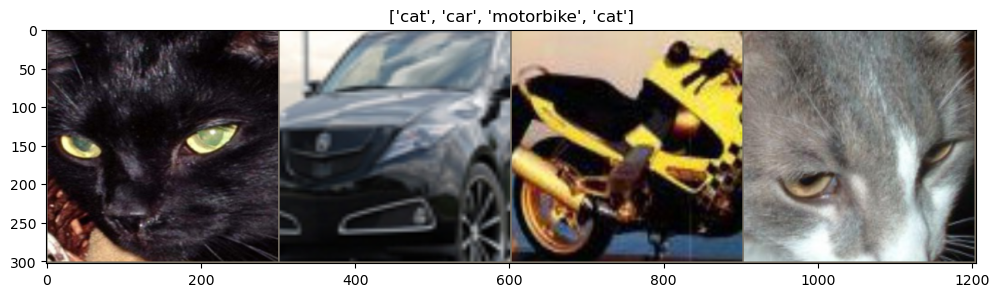

In [13]:
inputs, classes = iterate_dataloader(dataloaders['train'])
imshow(inputs, title=[class_names[x] for x in classes])

## Load DenseNet

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import models

model = models.densenet121(pretrained=True)

C:\Users\joseg\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\joseg\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\joseg/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 41.8MB/s]


In [15]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
num_ftrs = model.classifier.in_features
num_ftrs

1024

In [17]:
# 8 classes
model.classifier = nn.Linear(num_ftrs, 8)

In [18]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
criterion        = nn.CrossEntropyLoss()

optimizer_ft     = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, 
                    total_batch_sizes, batch_size, num_epochs=5)

Epoch 0/4
----------


C:\Users\joseg\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 2.3962 Acc: 0.8058
test Loss: 0.5622 Acc: 0.9493
Epoch 1/4
----------
train Loss: 1.3684 Acc: 0.8844
test Loss: 0.6536 Acc: 0.9428
Epoch 2/4
----------
train Loss: 1.1450 Acc: 0.9120
test Loss: 0.4683 Acc: 0.9529
Epoch 3/4
----------
train Loss: 0.9598 Acc: 0.9197
test Loss: 0.4850 Acc: 0.9551
Epoch 4/4
----------
train Loss: 0.9317 Acc: 0.9212
test Loss: 0.6700 Acc: 0.9457
Training complete
Best val Acc: 0.955072


In [31]:
# save the model with new learned parameters
# torch.save(model.state_dict(),'models/model.pt')

In [21]:
evaluate_model(model, dataloaders['test'])

Accuracy of the model on the test images: 96.23188405797102%


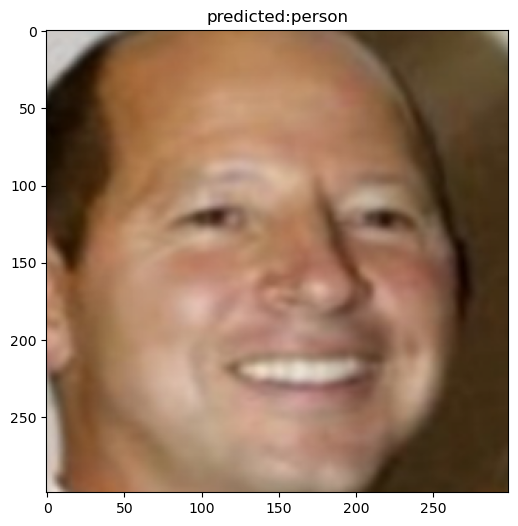

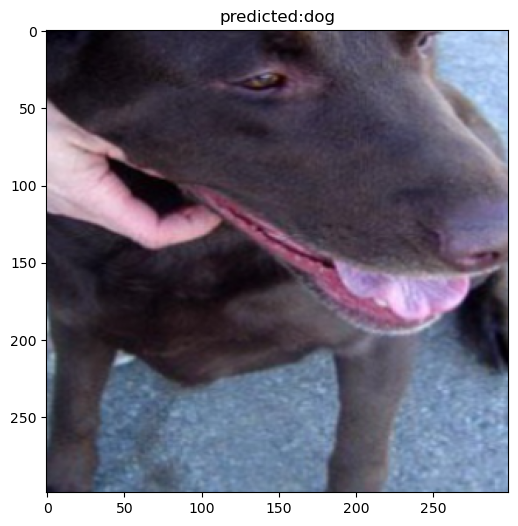

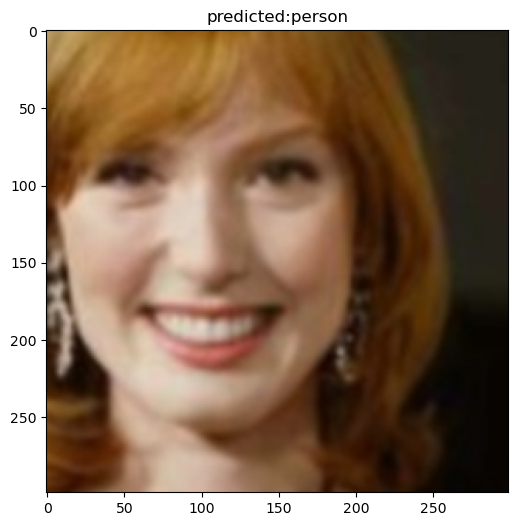

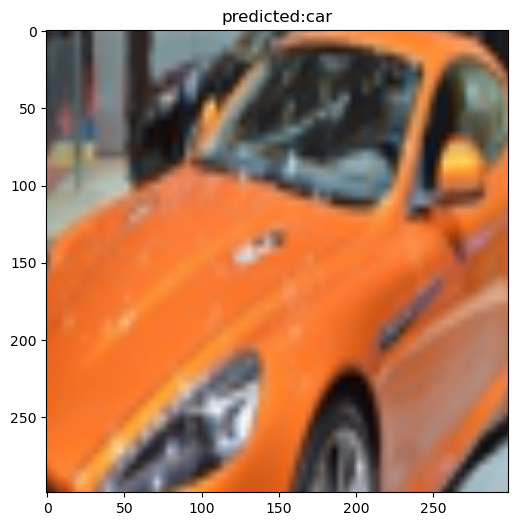

In [22]:
show_predictions(model, dataloaders['test'], class_names)

In [23]:
import torch

def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

In [24]:
print_gpu_memory()

Allocated memory: 69.81 MB
Cached memory: 1112.00 MB


In [25]:
torch.cuda.empty_cache()
print_gpu_memory()

Allocated memory: 69.81 MB
Cached memory: 114.00 MB
